# Tutorial 1: MuCoST using squidpy

## import MuCoST

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from MuCoST.mucost import training_model
from MuCoST.utils import mclust
from MuCoST.config import set_arg
import anndata as ad
import squidpy as sq

## hyperparameter setting

In [2]:
opt = set_arg()
arg = opt.parse_args(['--mode_his', 'noh'])
arg.n_domain=15
arg.temp=0.05
arg.use_eattr=True
arg.e_attr=0.5
arg.latent_dim=30
arg.cut_corr=True
arg.corr=0.5
arg

Namespace(seed=2023, latent_dim=30, epoch=1000, lr=0.001, weight_decay=0.0, log_step=10, drop_feat_p=0.2, flow='source_to_target', radius=150, hvg_n=3000, rknn=6, knn=6, n_domain=15, temp=0.05, n_refine=25, mode_his='noh', mode_rknn='rknn', e_attr=0.5, use_eattr=True, corr=0.5, cut_corr=True)

## reading data

In [3]:
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()
adata

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## showing ground truth

In [4]:
adata.obs['cluster']

AAACAAGTATCTCCCA-1             Cortex_2
AAACAATCTACTAGCA-1             Cortex_5
AAACACCAATAACTGC-1           Thalamus_2
AAACAGAGCGACTCCT-1             Cortex_5
AAACCGGGTAGGTACC-1           Thalamus_2
                            ...        
TTGTTGTGTGTCAAGA-1    Lateral_ventricle
TTGTTTCACATCCAGG-1       Hypothalamus_1
TTGTTTCATTAGTCTA-1       Hypothalamus_1
TTGTTTCCATACAACT-1           Thalamus_2
TTGTTTGTGTAAATTC-1             Cortex_4
Name: cluster, Length: 2688, dtype: category
Categories (15, object): ['Cortex_1', 'Cortex_2', 'Cortex_3', 'Cortex_4', ..., 'Pyramidal_layer_dentate_gyrus', 'Striatum', 'Thalamus_1', 'Thalamus_2']

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


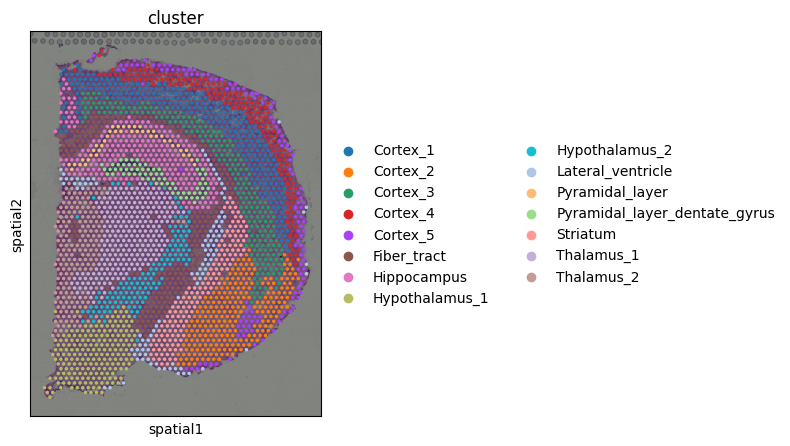

In [5]:
# Ann_df = pd.read_csv(os.path.join('Data/1-DLPFC_annotations', section_id+'_truth.txt'), sep='\t', header=None, index_col=0)
# Ann_df.columns = ['Ground Truth']
# adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, img_key="hires", color=["cluster"])

In [6]:
# sc.pl.spatial(adata, img_key="hires", color=["cluster"], groups=['Striatum','Hypothalamus_1','Pyramidal_layer','Hippocampus','Pyramidal_layer_dentate_gyrus','Lateral_ventricle'])

## training model

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Average spatial edge: 5.7961309523809526
Average feature edge: 6.0


  0%|          | 0/1000 [00:00<?, ?it/s]

EP[ 100]: loss=0.7896.
EP[ 200]: loss=0.7168.
EP[ 300]: loss=0.6931.
EP[ 400]: loss=0.6800.
EP[ 500]: loss=0.6703.
EP[ 600]: loss=0.6643.
EP[ 700]: loss=0.6592.
EP[ 800]: loss=0.6548.
EP[ 900]: loss=0.6534.
EP[1000]: loss=0.6492.


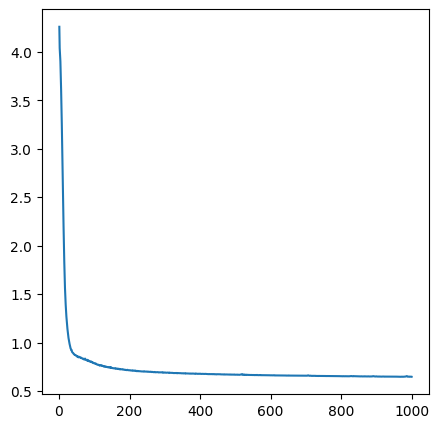

In [7]:
adata=training_model(adata, arg)

## clustering with muclust

In [8]:
adata = mclust(adata, arg, refine=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## computing ARI

In [9]:
adata = adata[~pd.isnull(adata.obs['cluster'])]
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['cluster'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.6307


## NMI

In [10]:
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi = normalized_mutual_info_score(obs_df['mclust'], obs_df['cluster'])
nmi

0.7601057568661808

## Homogeneity score

In [11]:
from sklearn.metrics import homogeneity_score
homogeneity = homogeneity_score( obs_df['cluster'],obs_df['mclust'])
homogeneity

0.7575652502933165

## Completeness score

In [12]:
from sklearn.metrics import completeness_score
completeness = completeness_score(obs_df['cluster'],obs_df['mclust'])
completeness

0.7626633600274696

## V_measure score

In [13]:
from sklearn.metrics import v_measure_score
v_measure = v_measure_score(obs_df['cluster'],obs_df['mclust'])
v_measure 

0.7601057568661809

## Compactness score

## UMAP visualization

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/z

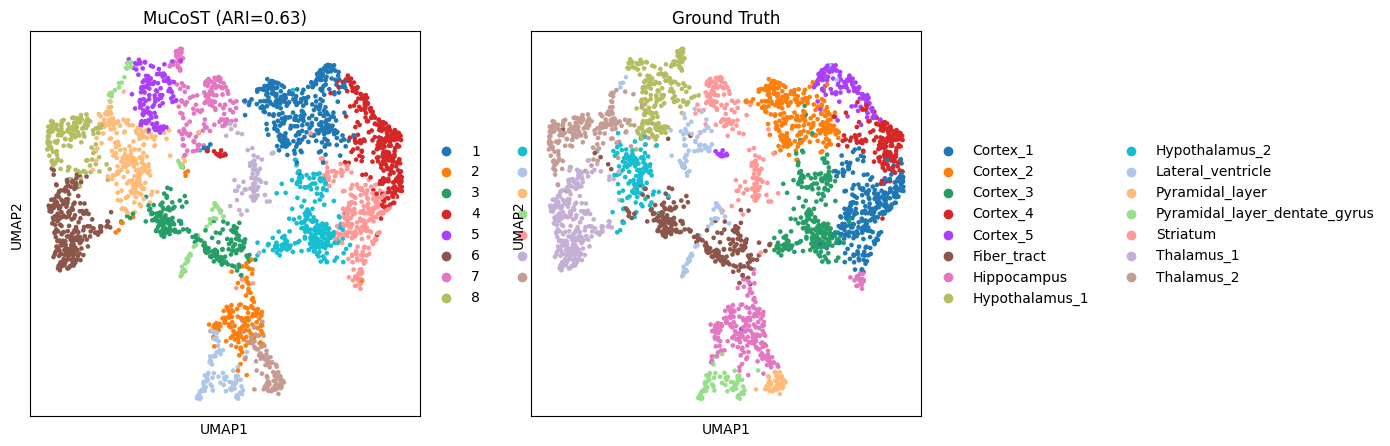

In [14]:
sc.pp.neighbors(adata, use_rep='MuCoST')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.umap(adata, color=["mclust", "cluster"], title=['MuCoST (ARI=%.2f)'%ARI, "Ground Truth"])

## heatmap of density

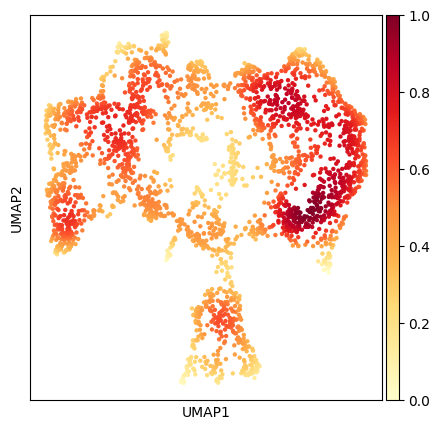

In [15]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.tl.embedding_density(adata, basis='umap')
sc.pl.embedding_density(adata, basis='umap',fg_dotsize=40)

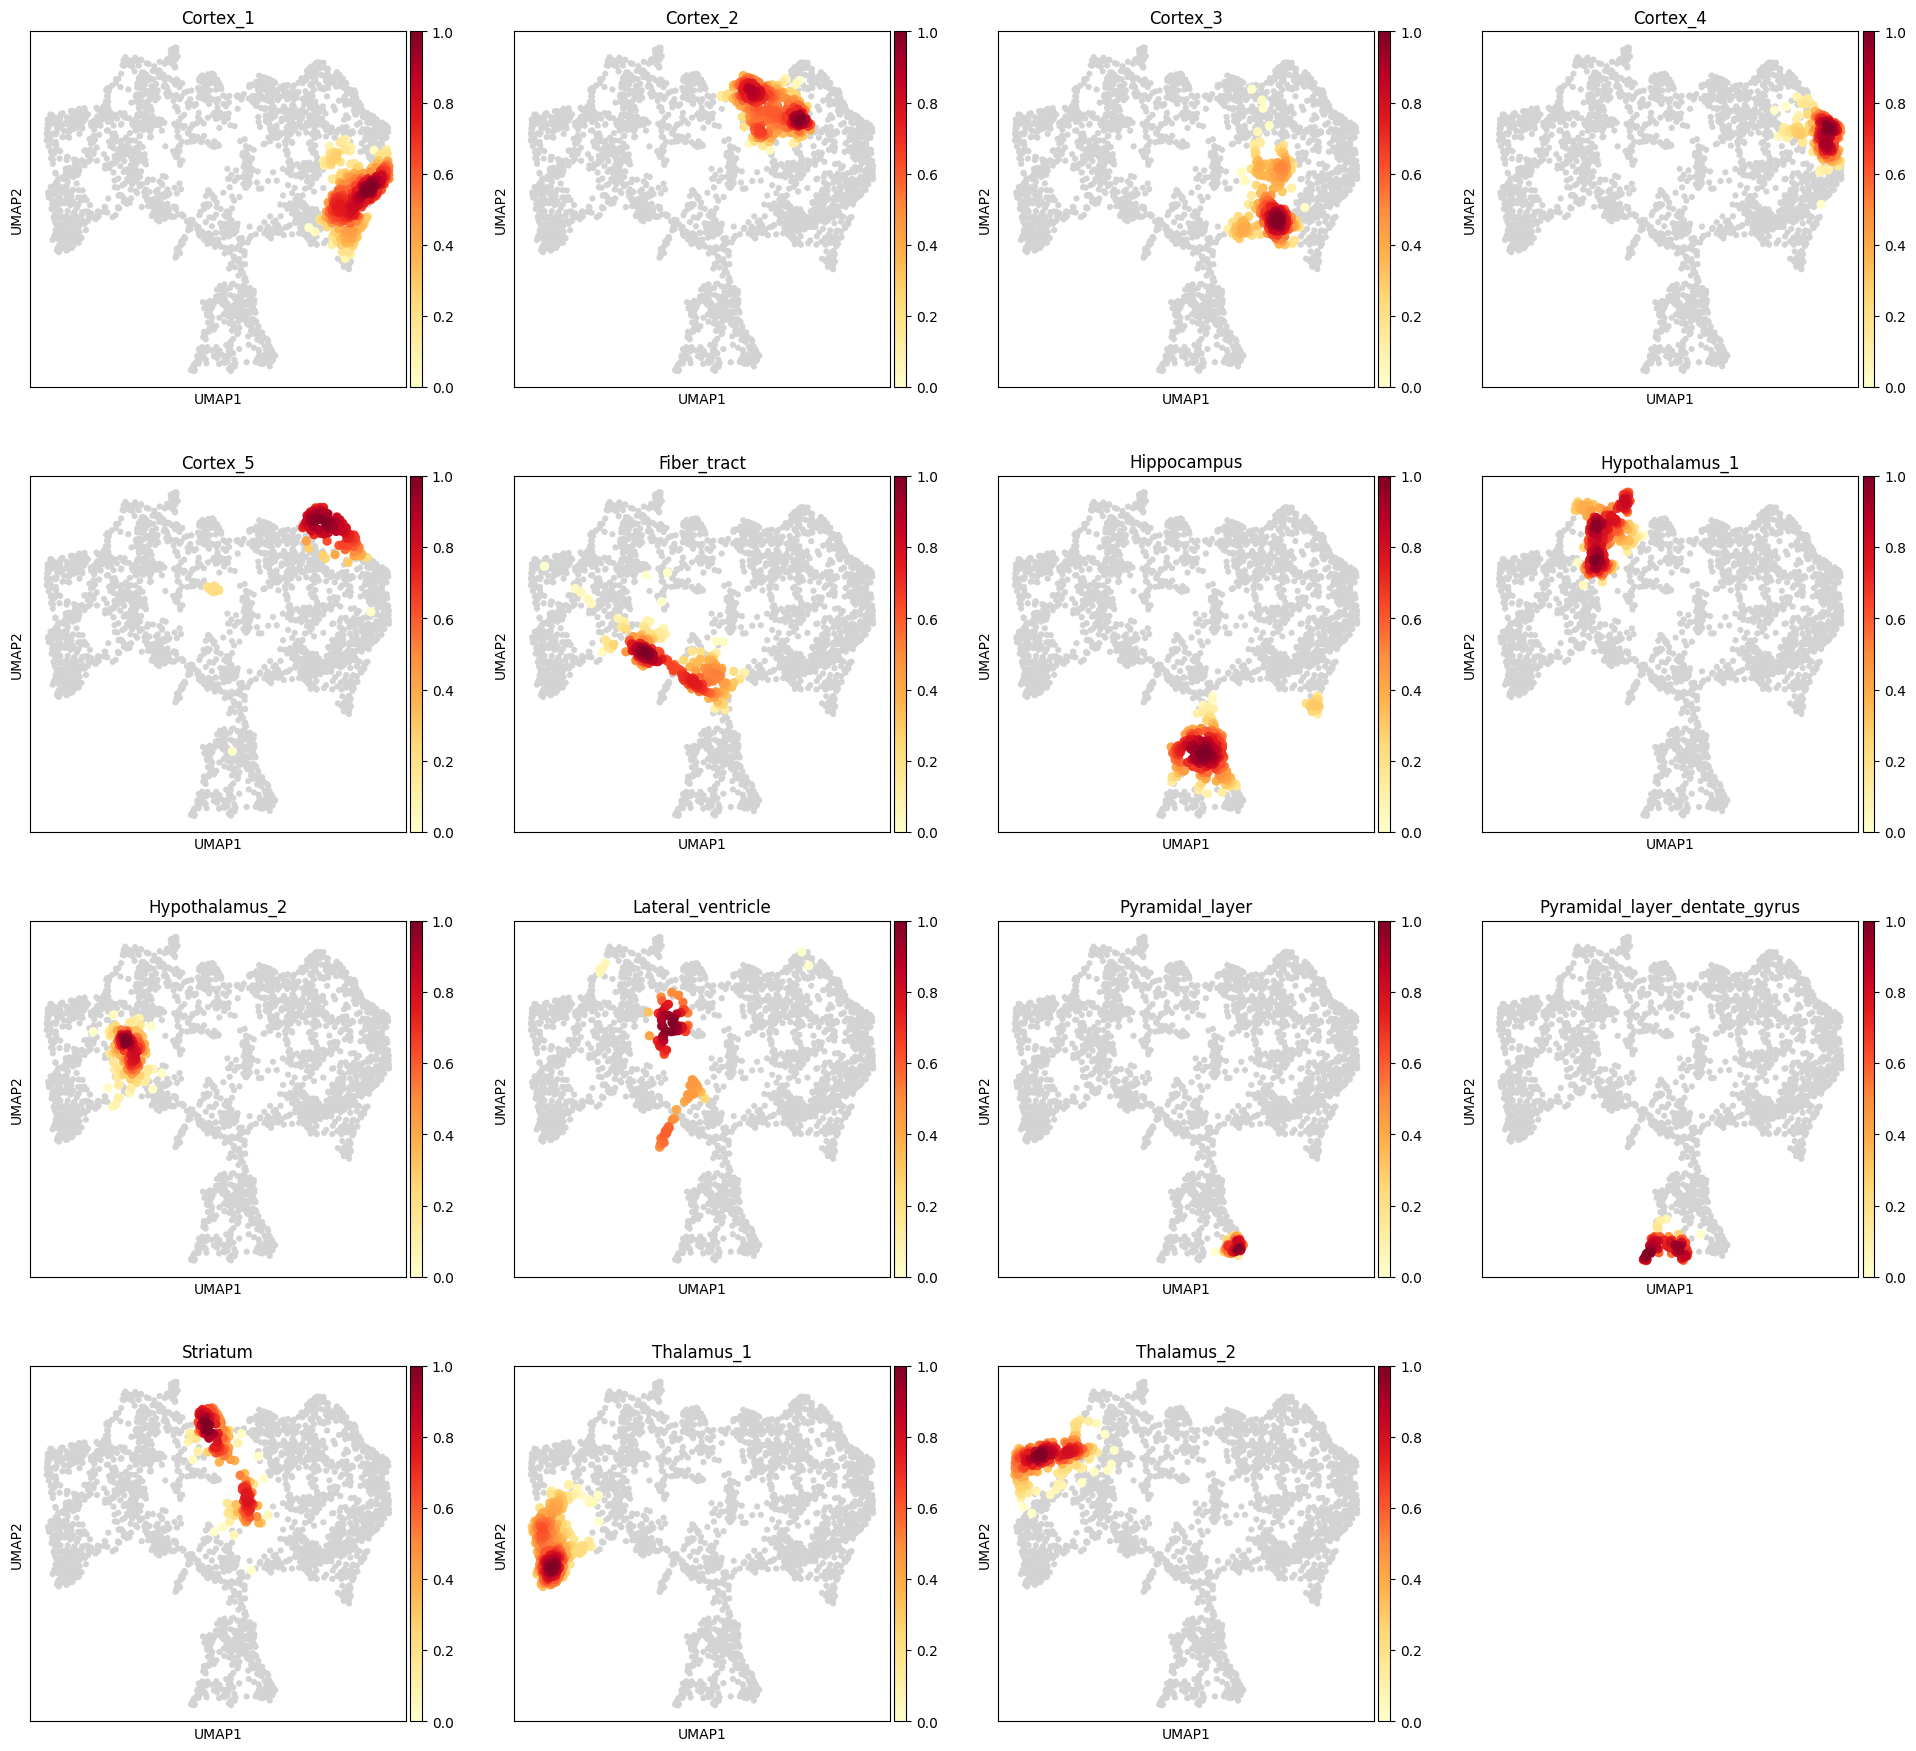

In [16]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.tl.embedding_density(adata, basis='umap', groupby='cluster')
sc.pl.embedding_density(adata, basis='umap', groupby='cluster')

## spatial architectures

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


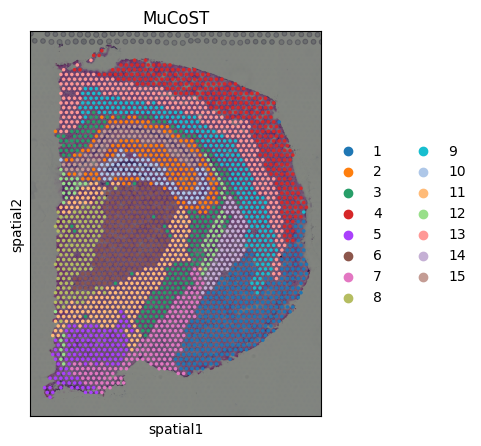

In [17]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, color=["mclust"], title=['MuCoST'])

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


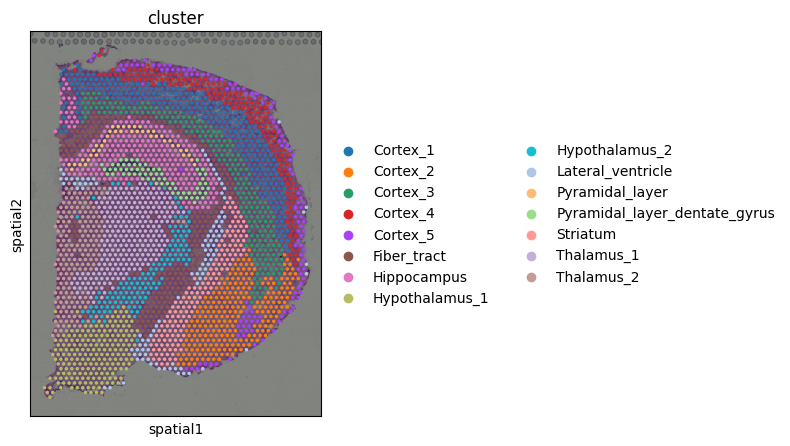

In [18]:
sc.pl.spatial(adata, img_key="hires", color=["cluster"])

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


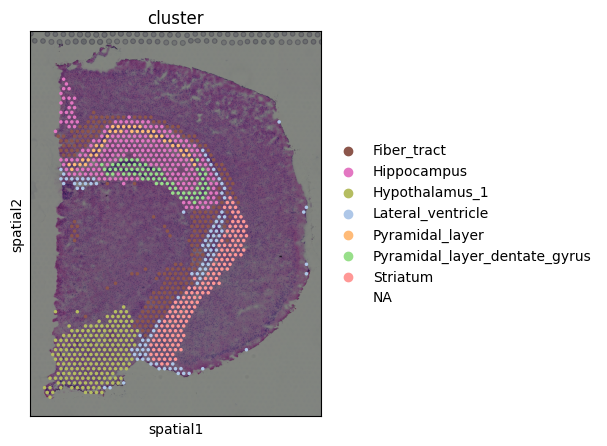

In [19]:
sc.pl.spatial(adata, img_key="hires", color=["cluster"], groups=['Hypothalamus_1','Fiber_tract','Striatum','Pyramidal_layer','Hippocampus','Pyramidal_layer_dentate_gyrus','Lateral_ventricle'])

/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


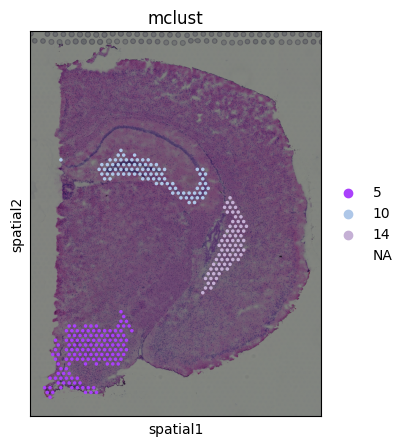

In [20]:
sc.pl.spatial(adata, img_key="hires", color=["mclust"], groups=[5,14,10])

In [21]:
# import warnings
# warnings.filterwarnings('ignore')
# plt.rcParams["figure.figsize"] = (5, 5)
# sc.tl.rank_genes_groups(adata, 'mclust', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)
# plt.rcParams['font.size'] = 16


/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/zl/anaconda3/envs/pyg/lib/python3.9/site-p

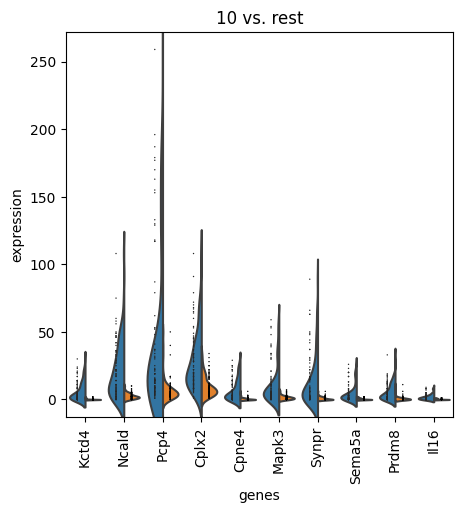

In [22]:
group = adata[(adata.obs['mclust']==10) | (adata.obs['mclust']==15)]
sc.tl.rank_genes_groups(group, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups_violin(group, groups=['10'], n_genes=10, jitter=False)

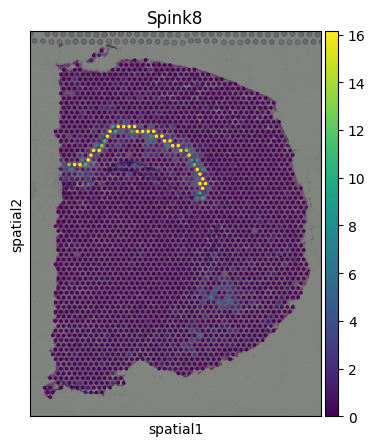

In [23]:
sc.pl.spatial(adata, img_key="hires", color='Spink8', show=True, vmax='p99')

In [24]:
# sc.pl.spatial(adata, img_key="hires", color='Agt', show=True, vmax='p99') #Cpne4 Synpr

In [25]:
# sc.pl.spatial(adata, img_key="hires", color='Plp1', show=True)

AAACAAGTATCTCCCA-1     1
AAACAATCTACTAGCA-1     4
AAACACCAATAACTGC-1     5
AAACAGAGCGACTCCT-1     4
AAACCGGGTAGGTACC-1     8
                      ..
TTGTTGTGTGTCAAGA-1    12
TTGTTTCACATCCAGG-1     5
TTGTTTCATTAGTCTA-1     5
TTGTTTCCATACAACT-1     8
TTGTTTGTGTAAATTC-1     4
Name: mclust, Length: 2688, dtype: category
Categories (15, int64): [1, 2, 3, 4, ..., 12, 13, 14, 15]


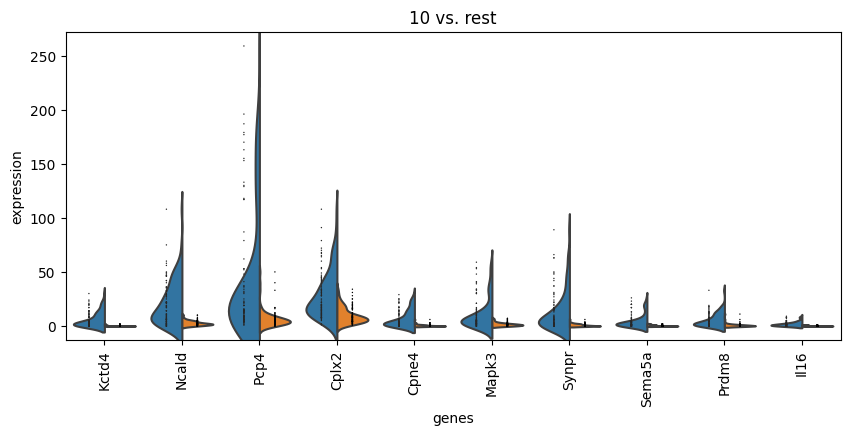

In [26]:
plt.rcParams["figure.figsize"] = (10, 4)
# plt.rcParams['font.size'] = 24
import warnings
warnings.filterwarnings('ignore')
# group = adata[(adata.obs['mclust']==9) |  (adata.obs['mclust']==4)]
group = adata[(adata.obs['mclust']==15) | (adata.obs['mclust']==10)]
print(adata.obs['mclust'])
sc.tl.rank_genes_groups(group, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups_violin(group, groups=['10'], n_genes=10, jitter=False)

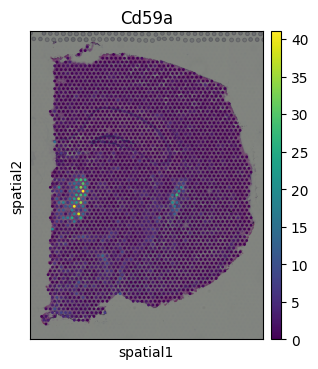

In [27]:
sc.pl.spatial(adata, img_key="hires", color='Cd59a', show=True)

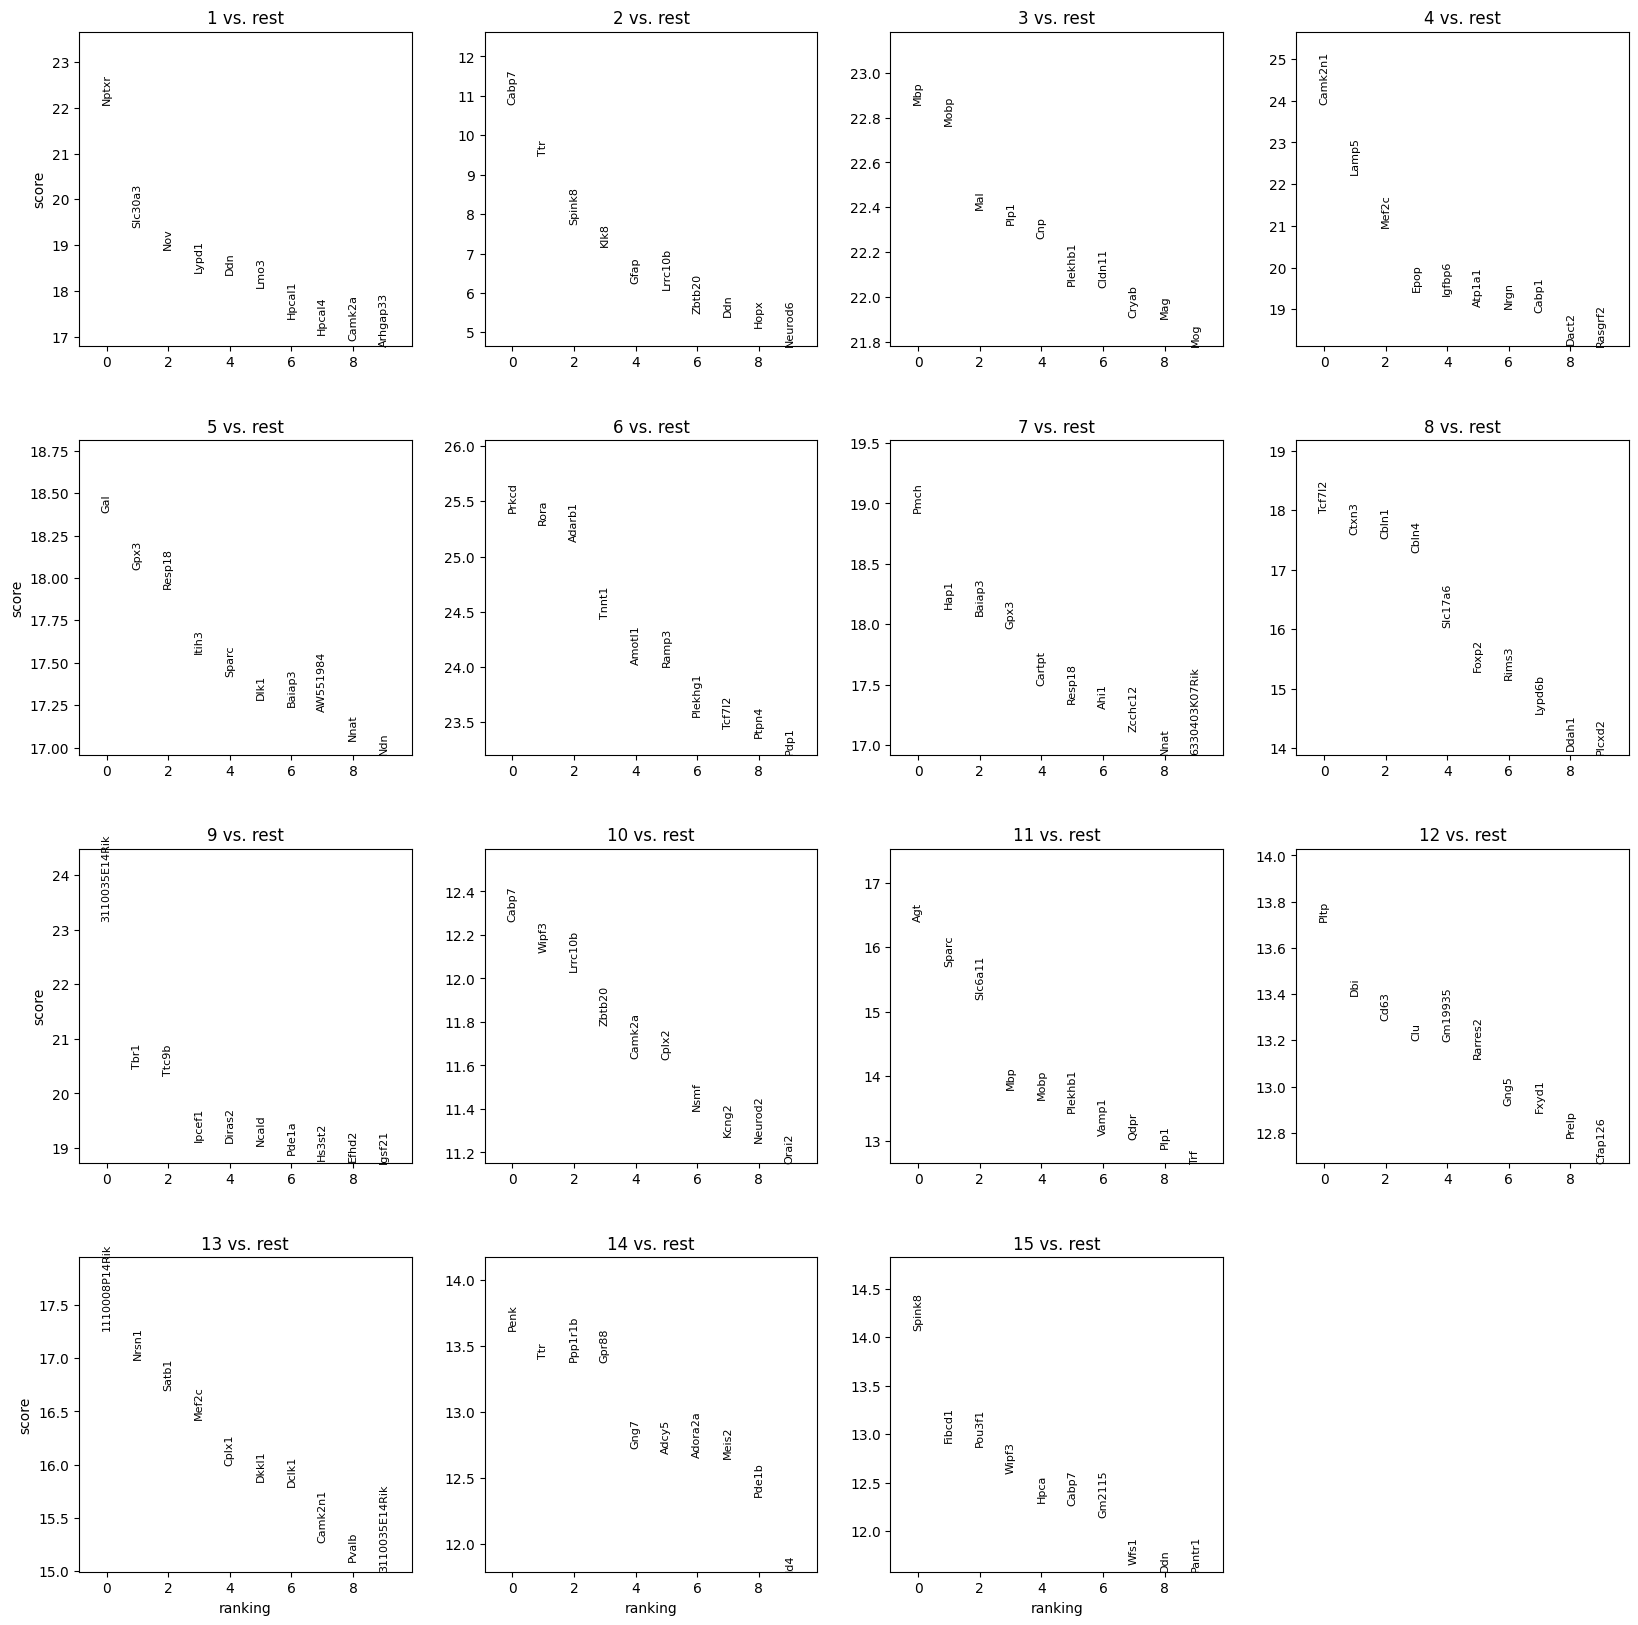

In [28]:
plt.rcParams["figure.figsize"] = (5, 5)
# plt.rcParams['font.size'] = 12
sc.tl.rank_genes_groups(adata, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

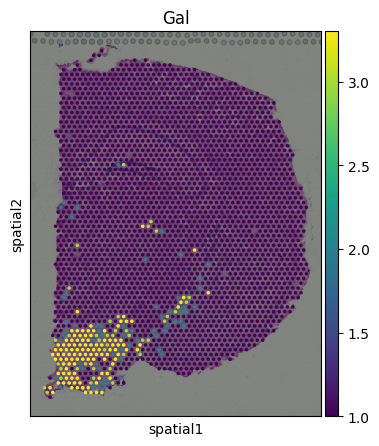

In [29]:
sc.pl.spatial(adata, img_key="hires", color='Gal', show=True, vmin=1,vmax=3.3)

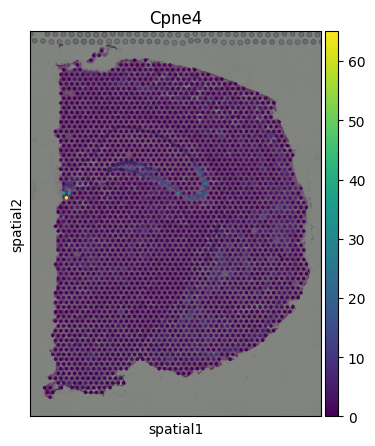

In [30]:

# plt.rcParams['font.size'] = 12
sc.pl.spatial(adata, img_key="hires", color='Cpne4', show=True)

In [31]:
# plot_color=[ "#ff7f0e", "#9467bd","#e377c2", "#8c564b", "#2ca02c","#1f77b4" , "#d62728"]
# plt.rcParams["figure.figsize"] = (5, 5)
# sc.pl.spatial(adata, color=["mclust"],palette=plot_color, title=['MuCoST (ARI=%.2f)'%ARI])

## paga trajectory inference

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

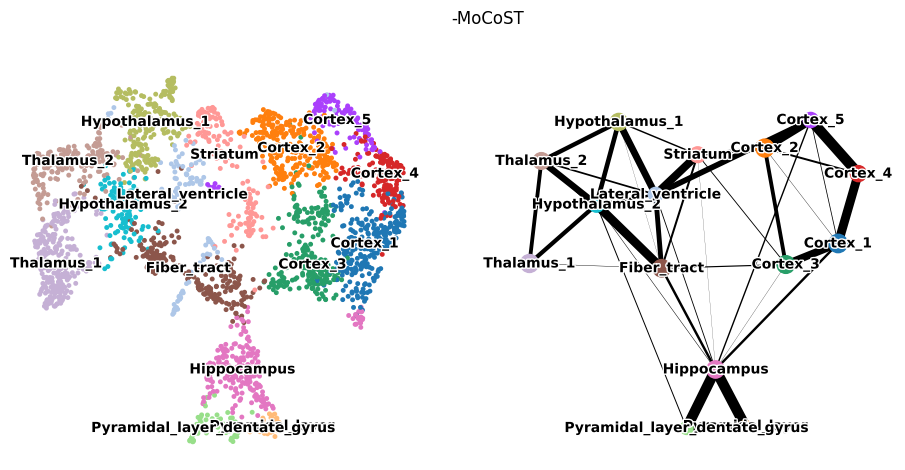

In [32]:
adata = adata[adata.obs['cluster'].notna(),:]
sc.tl.paga(adata,groups='cluster')
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.paga_compare(adata, legend_fontsize=10, frameon=False, size=50,
                   title='-MoCoST', legend_fontoutline=2, show=False)

  0%|          | 0/1000 [00:00<?, ?/s]

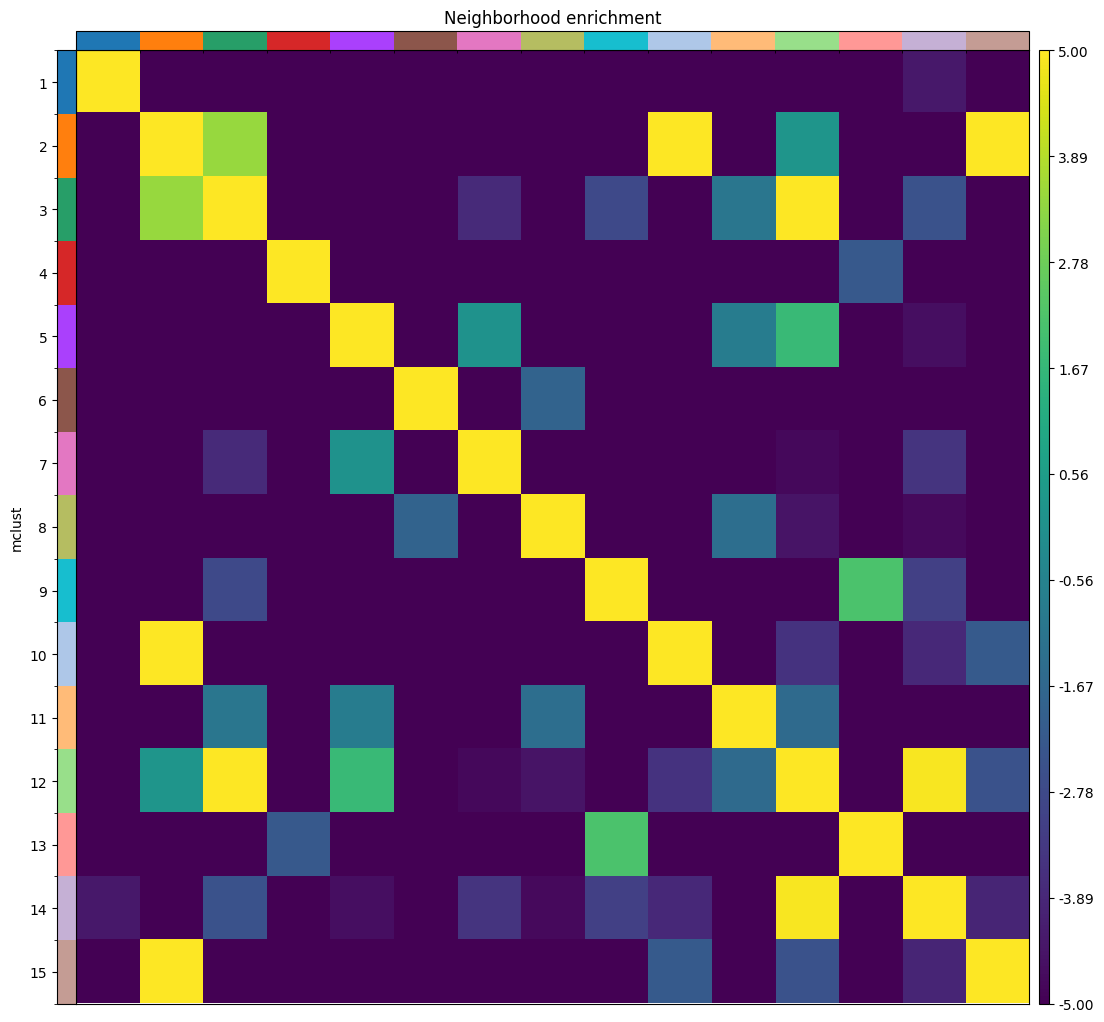

In [33]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="mclust")
sq.pl.nhood_enrichment(adata, cluster_key="mclust", vmax=5, vmin=-5)

  0%|          | 0/1 [00:00<?, ?/s]

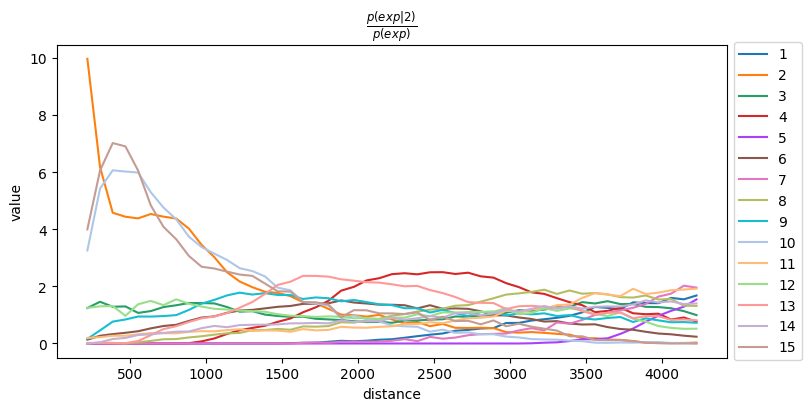

In [34]:
sq.gr.co_occurrence(adata, cluster_key="mclust")
sq.pl.co_occurrence(
    adata,
    cluster_key="mclust",
    clusters=2,
    figsize=(8, 4),
)

In [35]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'mclust', 'umap_density', 'umap_density_cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'log1p', 'mclust_colors', 'umap_density_params', 'umap_density_cluster_params', 'paga', 'cluster_sizes', 'spatial_neighbors', 'mclust_nhood_enrichm

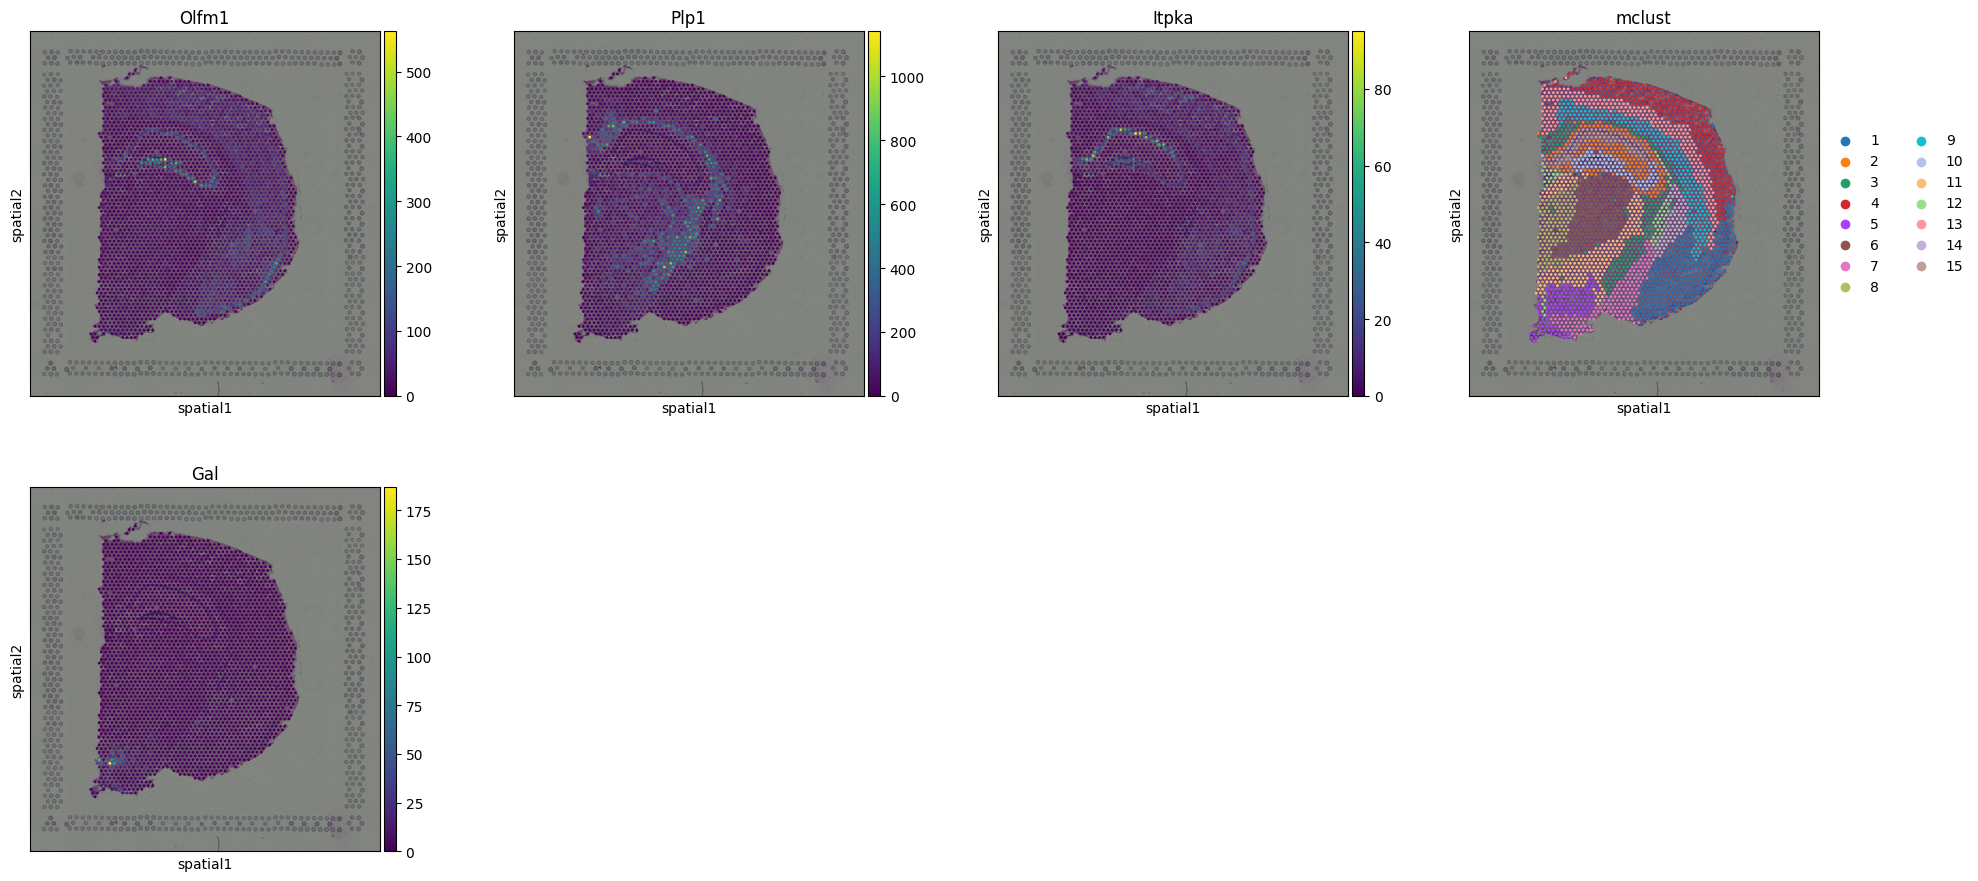

In [36]:
sq.pl.spatial_scatter(adata, color=["Olfm1", "Plp1", "Itpka", "mclust", 'Gal'])

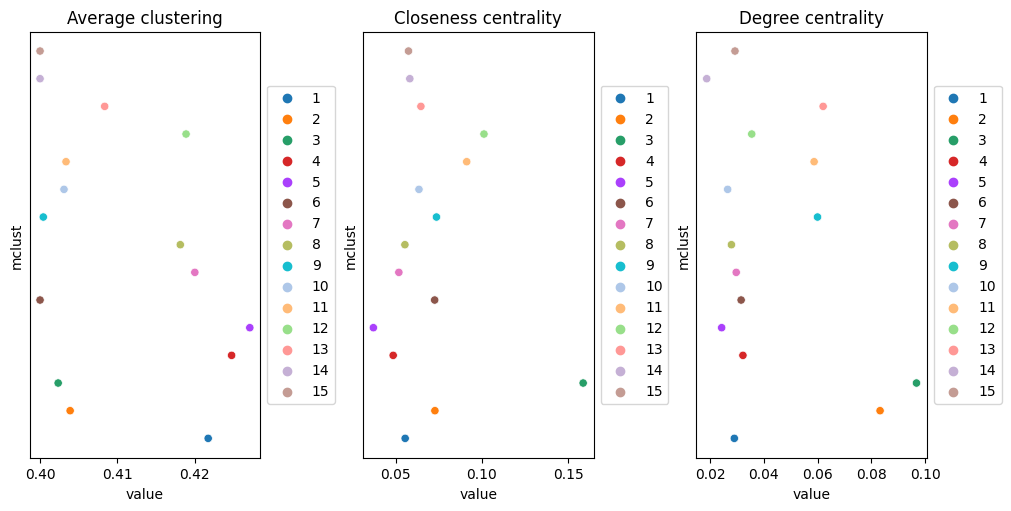

In [37]:
plt.rcParams["figure.figsize"] = (10, 5)
# plt.rcParams['font.size'] = 12
sq.gr.centrality_scores(adata, cluster_key='mclust')
sq.pl.centrality_scores(adata, cluster_key='mclust')


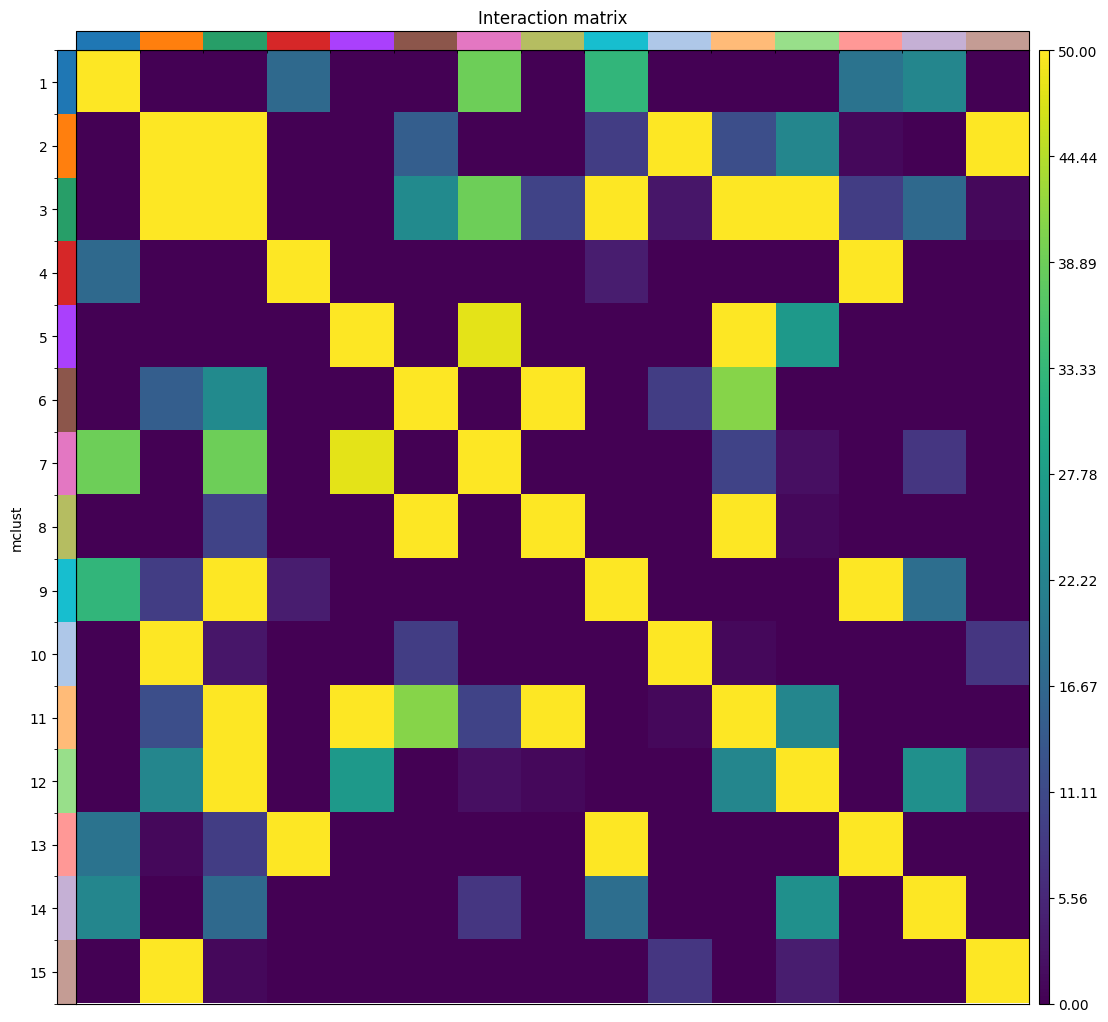

In [38]:
sq.gr.interaction_matrix(adata, 'mclust')
sq.pl.interaction_matrix(adata, 'mclust',vmax=50,vmin=0)

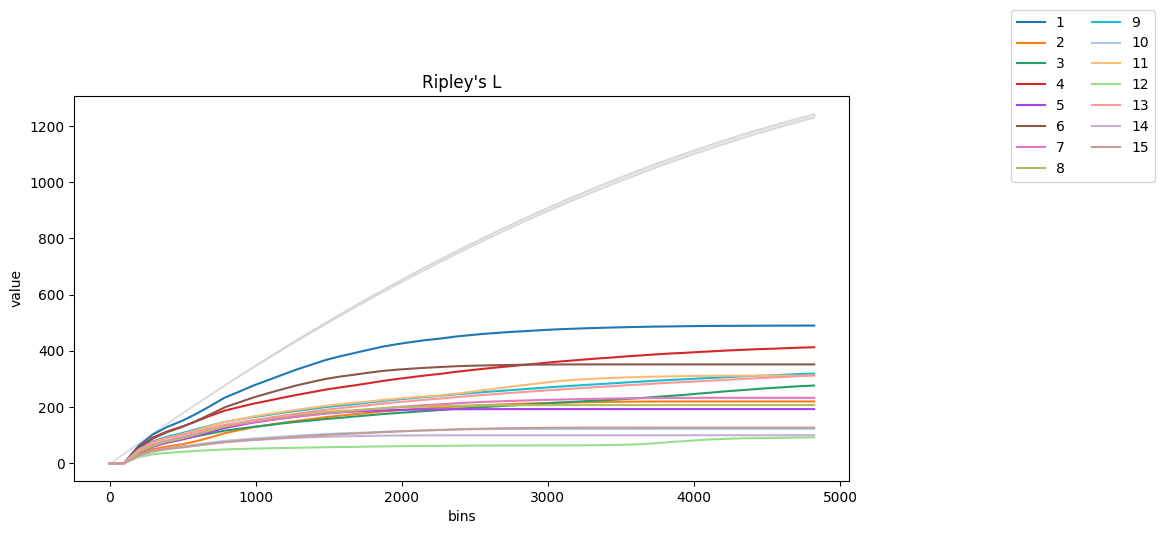

In [39]:
# plt.rcParams['font.size'] = 24

sq.gr.ripley(adata, 'mclust',mode='L')
sq.pl.ripley(adata, 'mclust',mode='L')
plt.legend(loc='center left', bbox_to_anchor=(1.2, 1), ncol=2)

In [40]:
sq.gr.spatial_autocorr(adata, mode="moran")
num_view = 12
top_autocorr = (
    adata.uns["moranI"]["I"].sort_values(ascending=False).head(num_view).index.tolist()
)

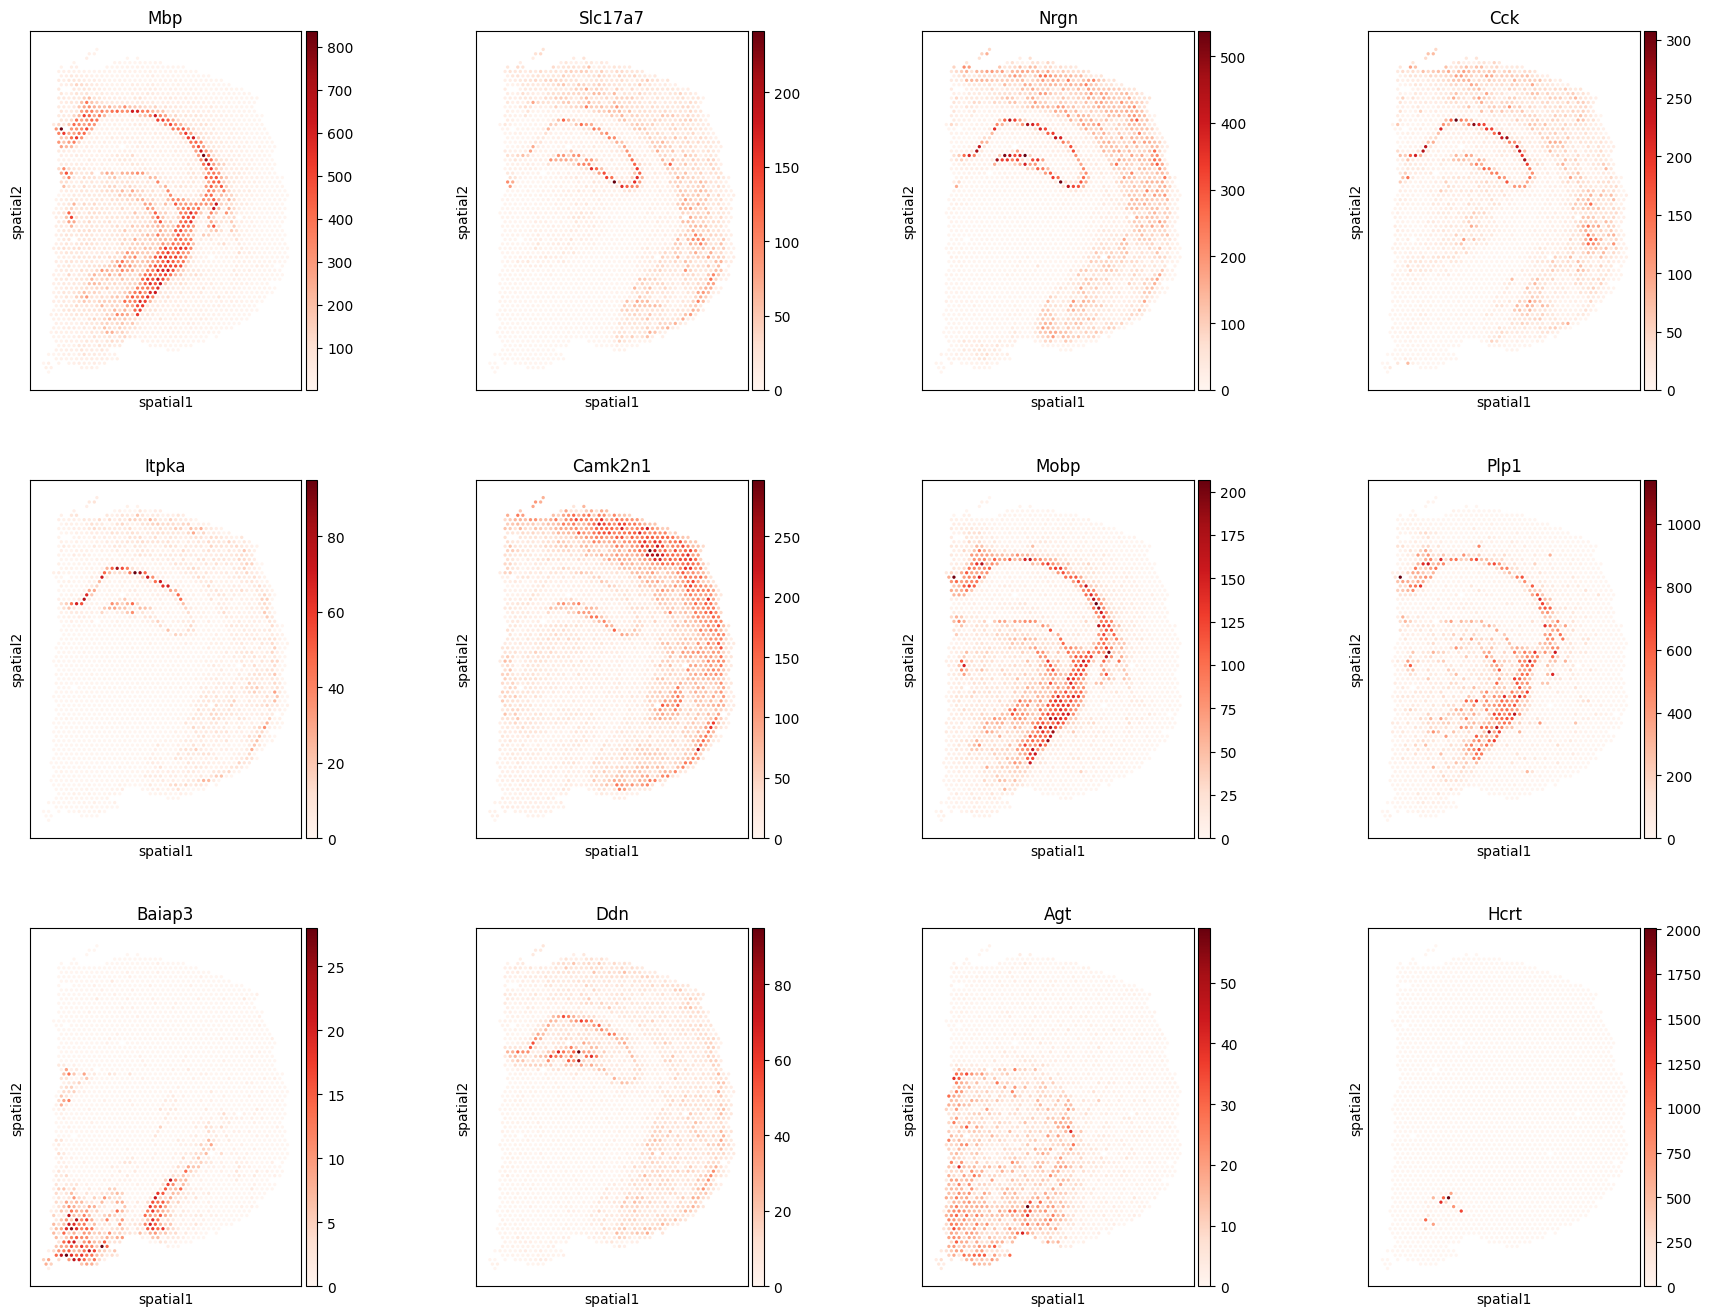

In [41]:
sq.pl.spatial_scatter(
    adata, color=top_autocorr, size=1, cmap="Reds", img=False, figsize=(5, 5)
)

In [42]:
bot_autocorr = (
    adata.uns["moranI"]["I"].sort_values(ascending=True).head(num_view).index.tolist()
)
bot_autocorr

['Ccdc18',
 'Cx3cr1',
 'P2ry13',
 'Tfcp2l1',
 'Alox5',
 'BC035044',
 'A530076I17Rik',
 'Slc35d2',
 'Nsl1',
 'Il1a',
 '4732471J01Rik',
 'Gm4675']

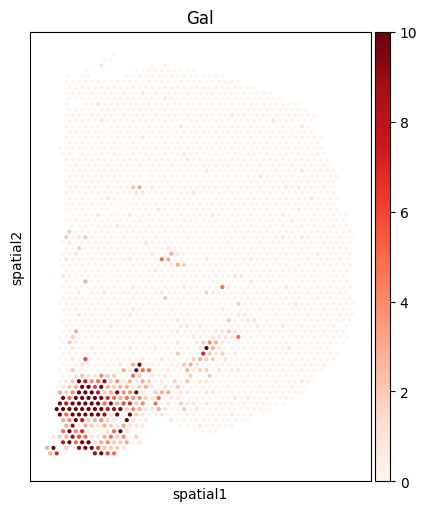

In [43]:
sq.pl.spatial_scatter(
    adata, color=['Gal'], size=1, cmap="Reds", img=False, figsize=(5, 5),vmax=10
)

In [44]:
sc.pp.neighbors(adata, use_rep='MuCoST')

In [45]:
sc.tl.leiden(adata, resolution=0.6)

In [46]:
adata = adata[~pd.isnull(adata.obs['cluster'])]
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['leiden'], obs_df['cluster'])
print('Adjusted rand index = %.2f' %ARI)

Adjusted rand index = 0.73


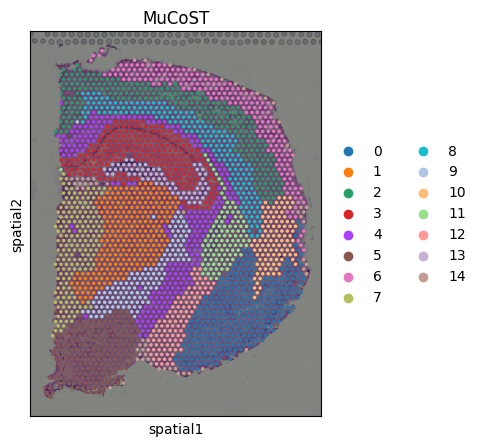

In [47]:
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, color=["leiden"], title=['MuCoST'])

In [48]:
sc.pp.neighbors(adata, use_rep='MuCoST')

In [49]:
sc.tl.louvain(adata, resolution=0.9)

Adjusted rand index = 0.72


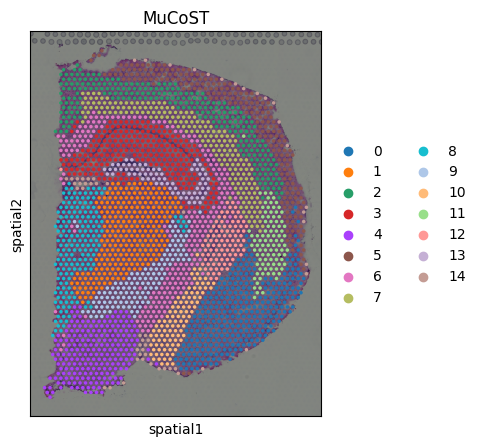

In [50]:
adata = adata[~pd.isnull(adata.obs['cluster'])]
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['louvain'], obs_df['cluster'])
print('Adjusted rand index = %.2f' %ARI)
plt.rcParams["figure.figsize"] = (5, 5)
sc.pl.spatial(adata, color=["louvain"], title=['MuCoST'])

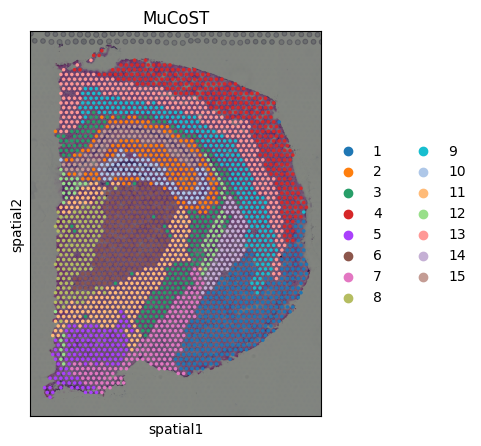

In [51]:
sc.pl.spatial(adata, color=["mclust"], title=['MuCoST'])

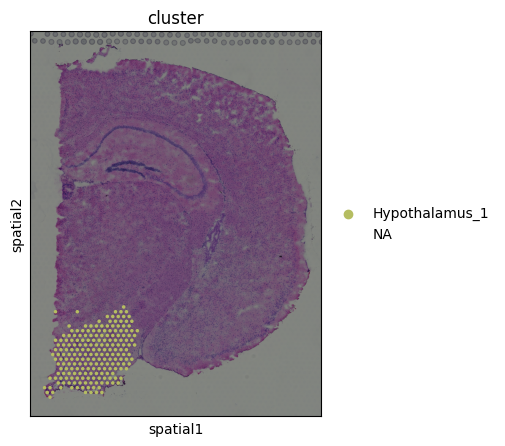

In [52]:
sc.pl.spatial(adata, img_key="hires", color=["cluster"], groups=['Hypothalamus_1'])

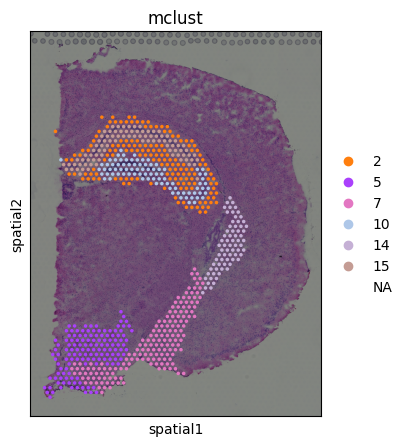

In [53]:
sc.pl.spatial(adata, img_key="hires", color=["mclust"], groups=[15,2,10,5,7,14])

AAACAAGTATCTCCCA-1     1
AAACAATCTACTAGCA-1     4
AAACACCAATAACTGC-1     5
AAACAGAGCGACTCCT-1     4
AAACCGGGTAGGTACC-1     8
                      ..
TTGTTGTGTGTCAAGA-1    12
TTGTTTCACATCCAGG-1     5
TTGTTTCATTAGTCTA-1     5
TTGTTTCCATACAACT-1     8
TTGTTTGTGTAAATTC-1     4
Name: mclust, Length: 2688, dtype: category
Categories (15, int64): [1, 2, 3, 4, ..., 12, 13, 14, 15]


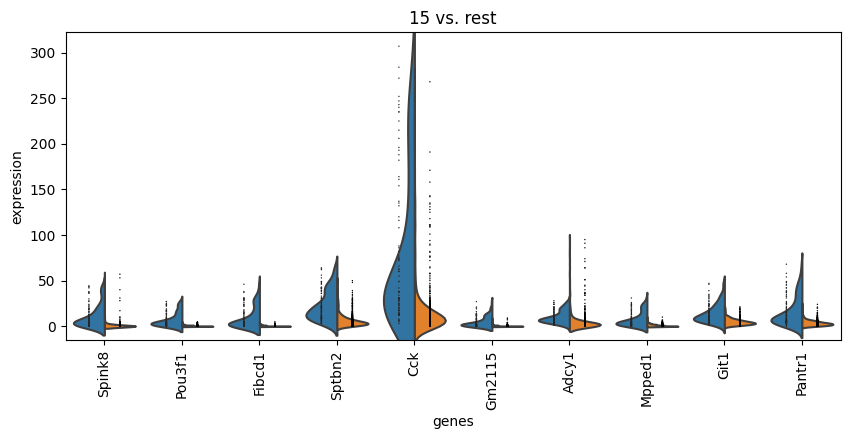

In [54]:
plt.rcParams["figure.figsize"] = (10, 4)
import warnings
warnings.filterwarnings('ignore')
group = adata[(adata.obs['mclust']==15) | (adata.obs['mclust']==2)| (adata.obs['mclust']==10)| (adata.obs['mclust']==5)| (adata.obs['mclust']==7)| (adata.obs['mclust']==14)]
print(adata.obs['mclust'])
sc.tl.rank_genes_groups(group, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups_violin(group, groups=['15'], n_genes=10, jitter=False)

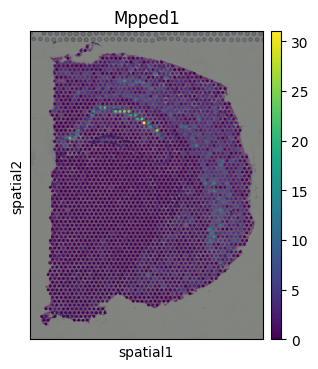

In [55]:
sc.pl.spatial(adata, img_key="hires", color='Mpped1', show=True)

AAACAAGTATCTCCCA-1     1
AAACAATCTACTAGCA-1     4
AAACACCAATAACTGC-1     5
AAACAGAGCGACTCCT-1     4
AAACCGGGTAGGTACC-1     8
                      ..
TTGTTGTGTGTCAAGA-1    12
TTGTTTCACATCCAGG-1     5
TTGTTTCATTAGTCTA-1     5
TTGTTTCCATACAACT-1     8
TTGTTTGTGTAAATTC-1     4
Name: mclust, Length: 2688, dtype: category
Categories (15, int64): [1, 2, 3, 4, ..., 12, 13, 14, 15]


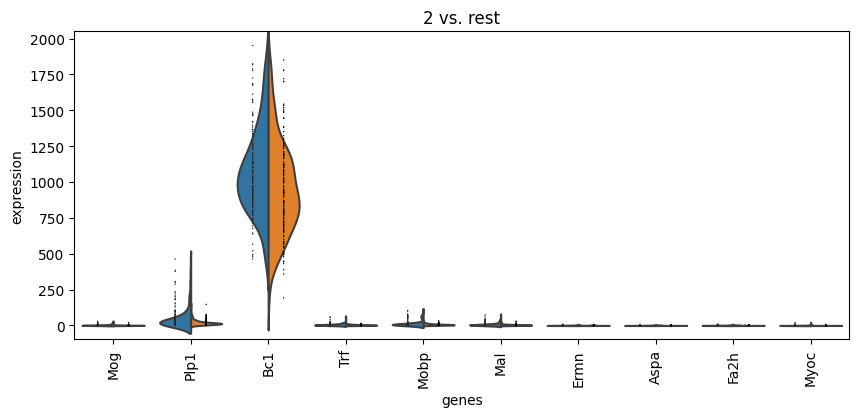

In [56]:
plt.rcParams["figure.figsize"] = (10, 4)
import warnings
warnings.filterwarnings('ignore')
group = adata[(adata.obs['mclust']==15) | (adata.obs['mclust']==2)| (adata.obs['mclust']==10)]
print(adata.obs['mclust'])
sc.tl.rank_genes_groups(group, 'mclust', method='wilcoxon')
sc.pl.rank_genes_groups_violin(group, groups=['2'], n_genes=10, jitter=False)

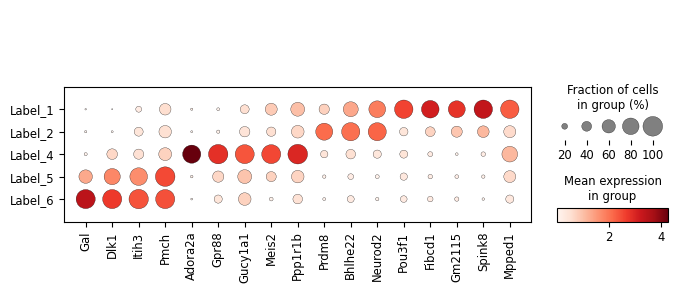

In [57]:
mark_genes = ['Gal','Dlk1','Itih3','Pmch',
              'Adora2a','Gpr88','Gucy1a1','Meis2','Ppp1r1b',
              'Prdm8','Bhlhe22','Neurod2',
              'Pou3f1','Fibcd1','Gm2115','Spink8','Mpped1']

selected_clusters = ['2', '5', '7','10','14','15']
selected_clusters = [5,7,10,14,15]
# 筛选数据
adata_selected = adata[adata.obs['mclust'].isin(selected_clusters)]

# # 创建基因表达矩阵
gene_expression = pd.DataFrame(adata_selected.X.todense(), index=adata_selected.obs_names, columns=adata_selected.var_names)

# # 创建新的AnnData对象
adata_filtered = sc.AnnData(X=gene_expression, obs=adata_selected.obs)

cluster_anno={'5':'Label_6','7':'Label_5','10':'Label_2','14':'Label_4','15':'Label_1'}
adata_filtered.obs['domain_type']=adata_filtered.obs['mclust'].astype('str').map(cluster_anno)

sc.pl.dotplot(adata_filtered , mark_genes, groupby='domain_type',dendrogram=False)